# __Puffins__

## NB 05 - Model stability as a function of N and N / p

As we saw in Notebooks 01 and 02, the Feature-Weight Least-Squares regression provides an apparently stable solution when comparing models trained on both 15,000 data points and only 1,500 data points.

In this notebook, we're going to systematically investigate how stable our model is for a range of N values and for a range of N / p values, where N is the number of data points and p is the number of features (columns in our design matrix).

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

from puffins.tuner import Tuner
from puffins.weight_functions import matern32
from puffins.data import TimeSeries,LinearModel
from puffins.uncertainties import UncertaintyEstimator
from puffins.basis_functions import basis_constant, basis_linear

np.random.seed(42) # to enforce reproducibility
RCOND = 1e-14 # numerical rounding for matrix conditioning
plotnum=1

You know the routine, unpack the data, simulate some _more or less_ realistic uncertainties, and tune our models hyperparameters.

In [2]:
time, flux = np.loadtxt('../data/ugru.dat').T
flux_err = np.random.normal(0,0.005,len(flux))
period = 1.88045
n_harmonics = 100
feature_weighting_width = 0.5

In [3]:
data = TimeSeries(time, flux)
fwls = LinearModel('fw', basis_functions=[basis_constant,], feature_embedding='fourier', 
                   feature_weighting_function=matern32, feature_weighting_width=feature_weighting_width,
                   period=period, n_harmonics=100, W=None)

In [4]:
joint_ = {'feature_weighting_width': [0.001,1,'uniform'], 'period': [1.87,1.89,'uniform']}
joint_tuner = Tuner(fwls, hyperpars=joint_, n_trials=200, direction='minimize')
joint_tuner.run_tune(data.predictors, data.targets)

[I 2025-02-07 15:54:29,140] A new study created in memory with name: no-name-2a757be3-de70-4105-97a6-0ea6285f3701
[I 2025-02-07 15:54:29,347] Trial 0 finished with value: 0.008064062002777194 and parameters: {'feature_weighting_width': 0.8188915978670656, 'period': 1.8836499392174317}. Best is trial 0 with value: 0.008064062002777194.
[I 2025-02-07 15:54:29,403] Trial 1 finished with value: 0.006373484494001758 and parameters: {'feature_weighting_width': 0.6591947691592918, 'period': 1.886552538503014}. Best is trial 1 with value: 0.006373484494001758.
[I 2025-02-07 15:54:29,460] Trial 2 finished with value: 0.0030271459246547804 and parameters: {'feature_weighting_width': 0.3942211613451906, 'period': 1.886370930953886}. Best is trial 2 with value: 0.0030271459246547804.
[I 2025-02-07 15:54:29,515] Trial 3 finished with value: 0.007942995277065419 and parameters: {'feature_weighting_width': 0.6925813740539578, 'period': 1.8887509003449023}. Best is trial 2 with value: 0.00302714592465

In [5]:
print(joint_tuner)
fwls.set_X_kwargs(update=True, **joint_tuner.best_hyperpars)
fwls.set_X_train(data.predictors)
fwls.train(data.targets)

Tuner:
 feature_weighting_width: 0.029615401409264518
period: 1.880469603963969


Great, now we have our model that was tuned to 100% of the data. 

First, at fixed p = 2 * n_harmonics + 1 = 201, we'll explore how the regression coefficients behave for decreasing N, in 5% increments.

In [6]:
n = len(time)
coefficients_i = []
means_i = []
vars_i = []

step_size = int(n * 0.05)

estimator = UncertaintyEstimator(data, fwls)

for step in range(step_size, n - step_size + 1, step_size):
    
    ddjk_i = estimator.run_delete_d_jackknife_sampling(n_groups=500, n_delete=step)
    coefficients_i.append(ddjk_i['sampled_coefs'])
    means_i.append(ddjk_i['coefs_mean'])
    vars_i.append(ddjk_i['coefs_var'])
    


Delete-d Jackkinfe Sampling: 100%|██████████| 500/500 [00:04<00:00, 100.31it/s]


In [7]:
coefficients_i = np.array(coefficients_i)
print(np.shape(coefficients_i[:,:,1]))
print(np.shape([step for step in range(step_size, n - step_size + 1, step_size)]))


(19, 500)
(19,)


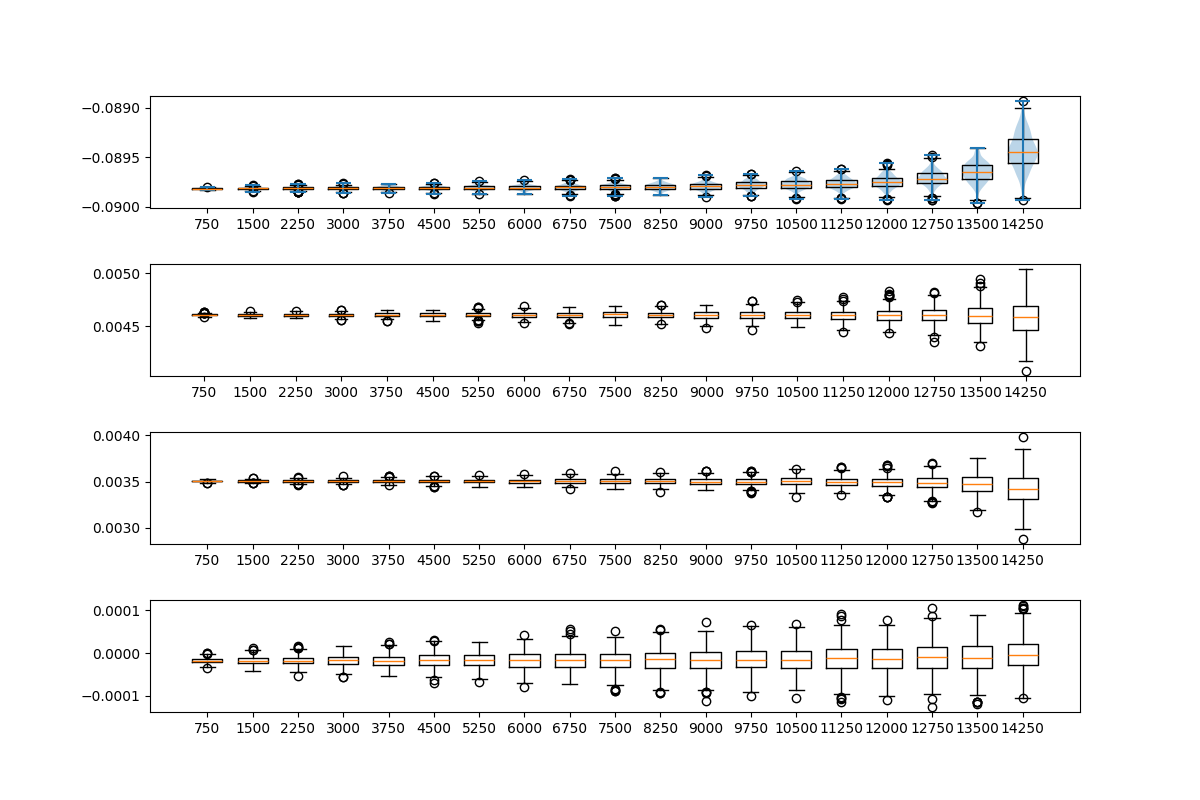

In [8]:
fig, ax = plt.subplots(4,1, figsize=(12,8))

# First harmonic cosine term
ax[0].boxplot( coefficients_i[:,:,1].T, positions=[step for step in range(step_size, n - step_size + 1, step_size)], widths=500)
ax[0].violinplot( coefficients_i[:,:,1].T, positions=[step for step in range(step_size, n - step_size + 1, step_size)], widths=500)

# Fifth harmonic cosine term
ax[1].boxplot( coefficients_i[:,:,11].T, positions=[step for step in range(step_size, n - step_size + 1, step_size)], widths=400)

# Tenth harmonic cosine term
ax[2].boxplot( coefficients_i[:,:,21].T, positions=[step for step in range(step_size, n - step_size + 1, step_size)], widths=500)


# 50th harmonic cosine term
ax[3].boxplot( coefficients_i[:,:,101].T, positions=[step for step in range(step_size, n - step_size + 1, step_size)], widths=500)

fig.subplots_adjust(hspace=0.5)


The x-axis represents the number of points __removed__ from the data set before fitting the regression model.
Incredibly, we can see that the feature-weighted regression solution is highly stable, even awhen we have just 10% of the data (750 points) remaining.

Why is this important? Well, it means that we have a roughly uniform basis against which we can compare the data with fairly different data sources (e.g. Kepler vs. Gaia).